In [8]:
from utilities import init_bigquery_client
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import plotly.express as px

#init BigQuery client
bq = init_bigquery_client()

Using BigQuery credentials: etl-testing-478716-c0b6c2c512e0.json


## Bulk Query

In [3]:
# Read from the 'user' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.users`
"""
users_df = bq.query(query).to_dataframe()

# Read from the 'friends' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.friends`
"""
friends_df = bq.query(query).to_dataframe()


/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


## Friend Graph

In [19]:
#creating dataframe with parent_id and friend_id info merged
merged_df = friends_df.merge(users_df, left_on='parent_id', right_on='user_id', how='left', suffixes=('_friend', '_user'))
merged_df = merged_df.rename(columns={'fullName': 'fullName_parent', 'username': 'username_parent'})

#merge to get friend info
merged_df = merged_df.merge(users_df, left_on='friend_id', right_on='user_id', how='left', suffixes=('', '_user2'))

merged_df = merged_df.rename(columns={'fullName': 'fullName_friend', 'username': 'username_friend',
                                       'businessUser': 'businessUser_parent', 'businessUser_user2': 'businessUser_friend',
                                       'contactAccessGranted': 'contactAccessGranted_parent', 'contactAccessGranted_user2': 'contactAccessGranted_friend'})

#cleaning columns
columns_to_keep = ['parent_id', 'friend_id', 'fullName_parent', 'username_parent', 'businessUser_parent',
                   'contactAccessGranted_parent', 'fullName_friend', 'username_friend', 'businessUser_friend',
                   'contactAccessGranted_friend']
merged_df = merged_df.drop(columns=[x for x in merged_df.columns if x not in columns_to_keep])
#dropping rows with missing names (user may have deleted account)
merged_df = merged_df.dropna(subset=['fullName_parent', 'fullName_friend'])

In [22]:
merged_df.head()

,parent_id,friend_id,fullName_parent,username_parent,contactAccessGranted_parent,businessUser_parent,fullName_friend,username_friend,contactAccessGranted_friend,businessUser_friend
0,0PNBuWC4P5by27fmCRYtT89Jdtl1,j9TDokuozyVw4cQIibWntIKL7iA3,trask dix,traskyall,False,False,Goodjuan,goodjuan,True,False
1,3dedM4sg6xZVoCDDkM5WWgDGhLd2,j9TDokuozyVw4cQIibWntIKL7iA3,Brandon Quick,brandonquick,True,False,Goodjuan,goodjuan,True,False
2,3dedM4sg6xZVoCDDkM5WWgDGhLd2,j9TDokuozyVw4cQIibWntIKL7iA3,Brandon Quick,brandonquick,True,False,Goodjuan,goodjuan,True,False
3,9gHK6nfBJrVyx1543vFgvOKL85N2,j9TDokuozyVw4cQIibWntIKL7iA3,Dane Iliff,dane,True,False,Goodjuan,goodjuan,True,False
4,HMNMQxE4ZlOqFietyb4bnTSHZEv2,C8m3vjY3F6cwmhVhwpnuhqYY0Je2,Danny Kopack,dannykopack,True,False,Michelle Prichard,michelleprichard,True,False


In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp

In [26]:
G = nx.from_pandas_edgelist(merged_df, 'parent_id', 'friend_id')

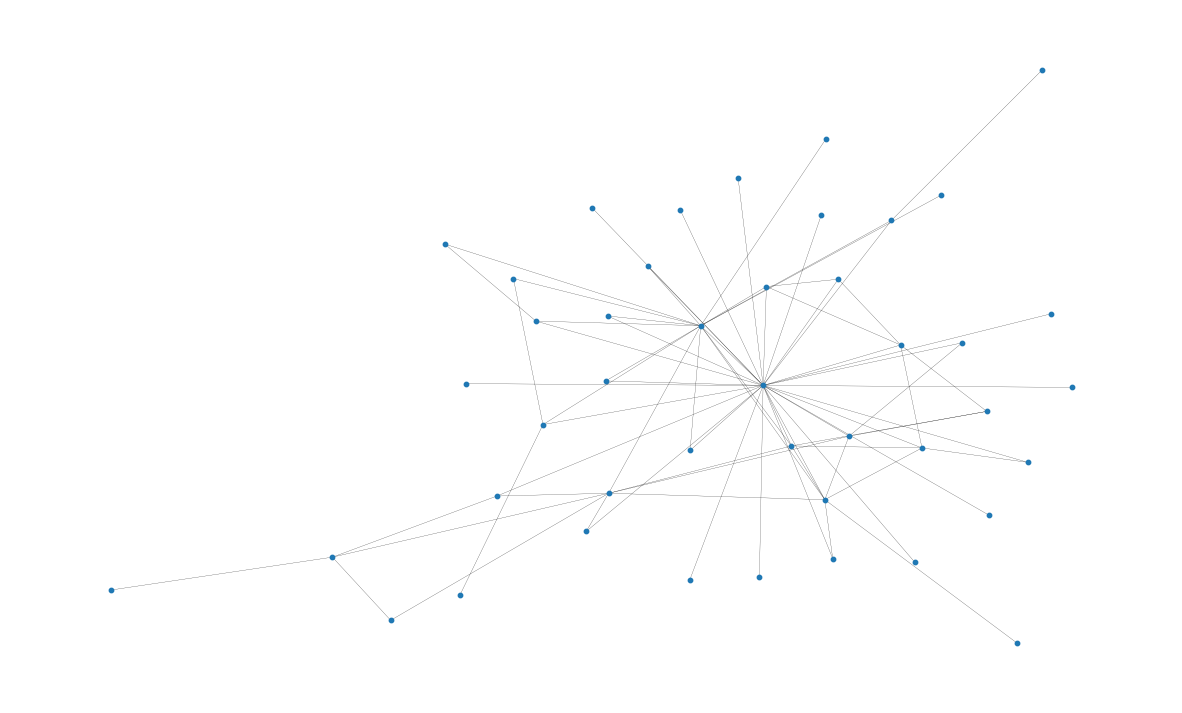

In [30]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

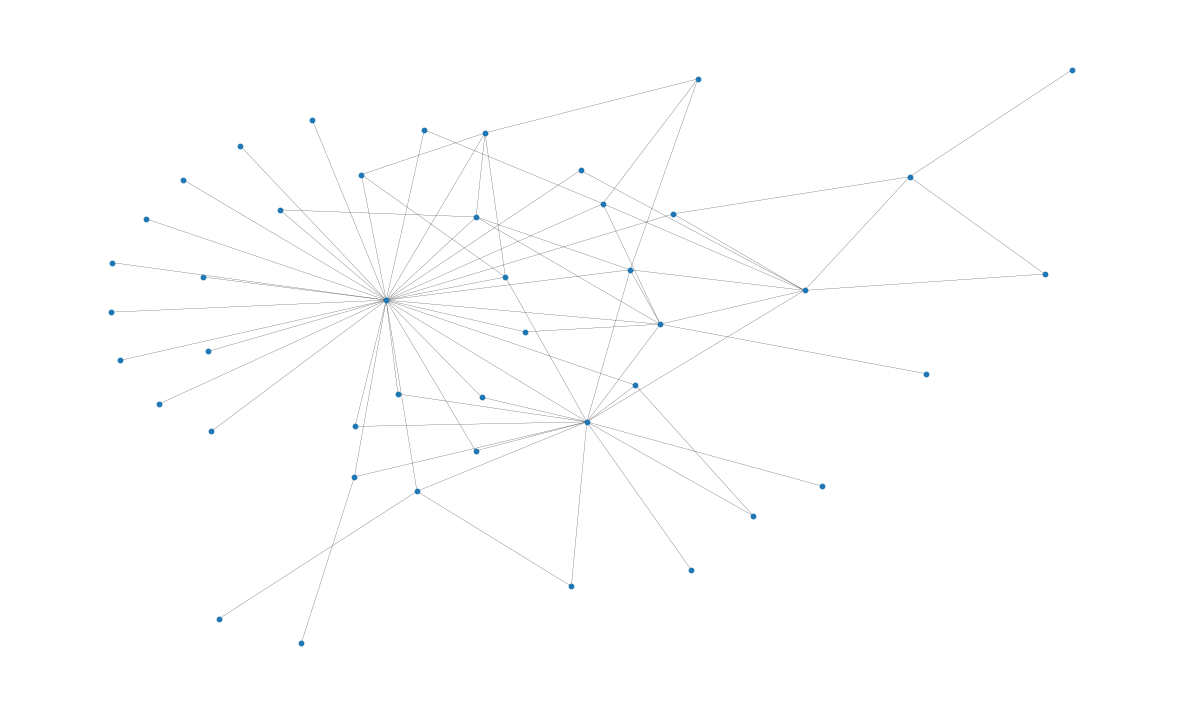

In [35]:
pos = nx.kamada_kawai_layout(G)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Network Overview 

In [39]:
#Average degree per node
np.mean([d for _, d in G.degree()])

np.float64(3.409090909090909)

In [41]:
#histogram of degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = pd.Series(degree_sequence).value_counts().sort_index()
fig = px.histogram(degree_count, x=degree_count.index, y=degree_count.values,
             labels={'x': 'Degree', 'y': 'Count'}, nbins=30,
             title='Degree Distribution of Friend Network')
fig.show()

In [42]:
#Shortest path lengths
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [44]:
#diameter of the graph
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

5

In [45]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

np.float64(2.2758264462809916)

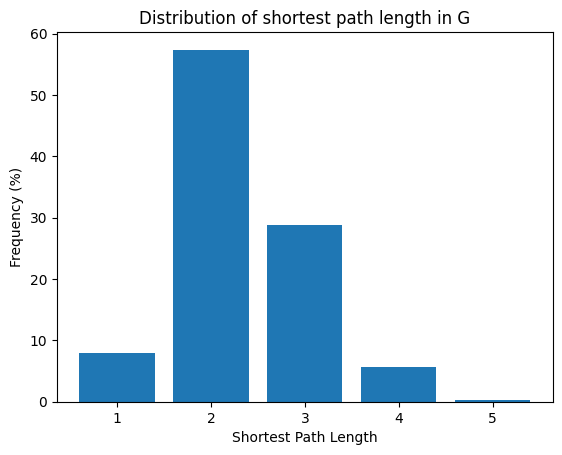

In [ ]:
#Histogram of shortest path lengths
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots()
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", loc="center"
)
ax.set_xlabel("Shortest Path Length")
ax.set_ylabel("Frequency (%)")
plt.show()

In [49]:
#Graph density 
nx.density(G)

0.07928118393234672

In [ ]:
#Number of components (Is everyone connected?)
nx.number_connected_components(G)

1

### Individual Importance

#### Degree Centrality

Degree centrality gives a ratio of degree/total network. Can be used to identify what users are the most connected in the network.

In [51]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again

(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.7209302325581395),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.37209302325581395),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.18604651162790697),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.18604651162790697),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.13953488372093023),
 ('9gHK6nfBJrVyx1543vFgvOKL85N2', 0.11627906976744186),
 ('7D0Z9VCQW4ZCbe9hgcO5OCkqkx23', 0.11627906976744186),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.11627906976744186)]

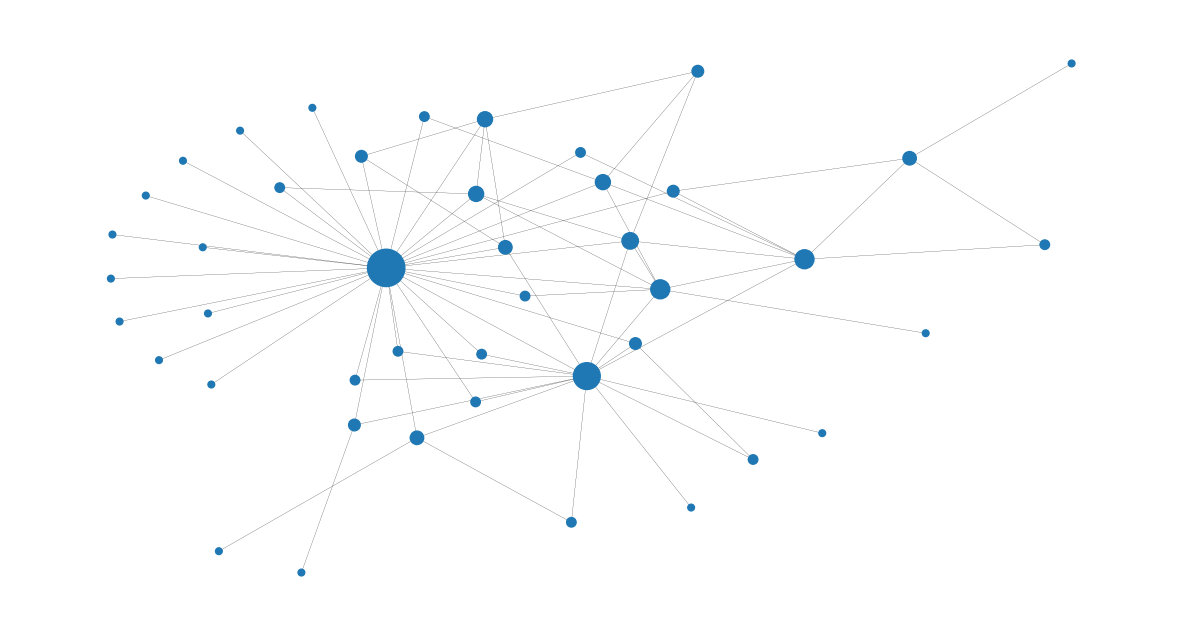

In [52]:
#Can replot with node size based on degree centrality
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

#### Closeness Centrality

Closeness centrality scores nodes by how quickly they can reach all other nodes, a high closeness means the node is closer to the center of the network? 

Who can reach everyone most quickly?

Closeness can be used to monitor for spread of information within the network. Can test if high closeness results in higher event attendance ?


In [53]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.7543859649122807),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.6056338028169014),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.5308641975308642),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.5180722891566265),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.48863636363636365),
 ('LoRFoglnbvaGpHBwEHq9HTusQXl2', 0.48314606741573035),
 ('70kQa5U1jON7g39vnkFnHDmxSsR2', 0.48314606741573035),
 ('lEPaZX3MRNNo4p7EQRnLNP0jPDl2', 0.4777777777777778)]

#### Eigenvector Centrality

Eigenvector Centrality measures how connected a node is to other important nodes, where importance is based on a node's connectivity and the subsequent connectivity of it's connections. 

Who is connected to other well-connected people?
- In many analyses eigenvector centrality is treated as the identifier for most important nodes

In [54]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.5588230820659669),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.36119397446458895),
 ('3dedM4sg6xZVoCDDkM5WWgDGhLd2', 0.25746611695216703),
 ('j9TDokuozyVw4cQIibWntIKL7iA3', 0.22797120211432376),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.18370643234387757),
 ('9gHK6nfBJrVyx1543vFgvOKL85N2', 0.1834199068079591),
 ('LoRFoglnbvaGpHBwEHq9HTusQXl2', 0.16875679596786286),
 ('wmPmh04DuUdXlbBkPTXL60ymfPi1', 0.16573697318114541),
 ('7D0Z9VCQW4ZCbe9hgcO5OCkqkx23', 0.15637698858401852),
 ('70kQa5U1jON7g39vnkFnHDmxSsR2', 0.142062799307997)]

#### Betweenness Centrality 

Betweenness centrality measures how often a node appears on the shortest path between other nodes which is then intepreted as a metric of bridging or brokering

In [ ]:
centrality = nx.betweenness_centrality(G, k=10, endpoints=True)

### Community Detection Algorithms

#community.greedy_modularity_communities